# Thought Process

Before diving into my commented code, I'd like to highlight my thought process.

First, I read the data and looked at cleanliness. For example, I noticed that there were 57 instances of repeated organization names. Upon closer inspection, several organizations with identical names had different features -- country, date founded, status, etc, so I operated under the assumption that these organizations were indeed different but I have a feeling this isn't true for all of them.

Next, I took stock of the statuses of GlobalGiving's nonprofit partners. As of the time this data was downloaded, roughly half of the nonprofits were delinquent. Of course, this doesn't speak to a monthly retention rate, because this is a summation of historical data going as far back as 2004. This was part of my process of getting familiar with the data.

To measure monthly retention rate, I looked for a status switch from vetted to nonvetted (delinquent) over the past year. I created new columns (months) with boolean values representing whether or not each organization (row) had an active vetted registration at the first date of each month. Then I created another set of columns (retention) with a boolean value representing whether or not each organization (row) retained its vetting status through the duration of that month. Finally, I calculated the monthly retention rate by summing all organizations with a vetted status in month X and dividing by the sum of all organizations retained throughought the duration of month X, multiplied by 100 to be reported as a percent. This metric doesn't take into account new organizations in this time period - that would be a percent change in net vetted organizations, which would actually have been easier to calculate. I also calculated the duration of each organization's time with GlobalGiving (expired_vetting date - original_vetting date).

For a nontechnical audience, the monthly retention rate can be explained as follows: 
This metric represents the percentage of organizations that had an active vetted status at the beginning of a month who retained their active vetted status throughout the duration of the month. So, for example, if Sep 2019 had a retention rate of 94% and if there were 100 active vetted organizations on Sep 1, 2019, then only 94 of those organizations would still be active on Oct 1, 2019.

# Next Steps

Regarding data preprocessing:
- More closely investigate the 57 redundant nonprofit names.
- More closely investigate the ~3800 rows that I dropped due to NaT vetting-related date values. With more scrutiny, there could be a better way to handle this, such as only dropping rows that have the vetting expiry column as NaT. Please note that this may change final monthly retention rate calculation results.

Code:
- Refactor code to make the retention rate calculation less manual
- This will enable the retention rate plot to easily extend further back in time

Conceptual:
- Vetting status is only one way to look at retention. Just because an organization has a vetted status, that doesn't necessarily mean the organization is actively pursuing projects and interacting with GlobalGiving's platform and network. With more time, I would also look at metrics that are more affirmative, such as time since most_recent_ project_creation_date, last_login, and most_recent_field_visit_date as well as monthly rates of fundraising [$/month and/or # unique transactions/month] for each organization. Granular transaction data would be be necessary.

Analytical:
- It would be interesting to compare characteristics of organizations that have a longer retention duration to those with shorter retention durations. One approach would be to separate organizations into quartiles, for example, based on retention duration and calculate median and mean values for noncategorical features (e.g. all_time_funds_raised hopefully normalized by organization size) and percentage makeup for categorical features (e.g. % from each country, or top 5 countries). More features could be pulled from the GlobalGiving api following a join on organization name or id. This type of analysis would lend insight into characteristics of easily retained vs not as easily retained organizations but would fall short of machine learning.

- Another more involved project would be to predict which organizations are at high risk of "churn" (classification) or to predict the mean time to churn (regression). What might this look like? Relevant features could be country, organization size, time since last field visit, status, transaction rates, and more. GlobalGiving has plenty of historical data that could be used for training and testing before deployment.

# Code

In [326]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.simplefilter(action='ignore')

In [327]:
# read data
data = pd.read_csv("globalgiving_data_analyst_take_home_data.csv")

In [328]:
data.head()

,id,name,status,country_of_registration,year_founded,original_vetting_approval_date,most_recent_vetting_approval_date,vetting_expiration_date,approx_annual_budget,number_of_currently_active_projects,...,most_recent_project_deactivation_date,last_login,completed_accelerator_program,number_of_field_visits,most_recent_field_visit_date,all_time_funds_raised,all_time_unique_donors,acquisition_source_category,all_time_unque_project_themes,active_contacts
0,8,World Camp,Delinquent - Due Diligence,United States,2001.0,2013-02-26,2013-02-26,2015-02-26,130069.0,0.0,...,2005-03-17 00:00:00,2012-11-30 13:39:52,0,NaN,NaN,411.41,5,word_of_mouth,"Climate Action,Education,Ecosystem Restoration...",1
1,11,Samadhan,Partner,India,1981.0,2010-07-16,2019-10-10,2021-10-10,58078.0,1.0,...,2012-09-28 16:40:09,2020-09-08 02:22:23,0,3.0,2019-07-02,49177.39,244,field,"Child Protection,Economic Growth,Education,Gen...",3
2,12,Ruchika Social Service Organisation,Leader,India,1985.0,2011-11-14,2020-01-06,2022-01-06,407798.0,4.0,...,2008-02-13 00:00:00,2020-06-17 05:52:53,0,3.0,2019-06-10,168601.72,423,renewal,"Child Protection,Education,Ecosystem Restorati...",3
3,15,"Carolina for Kibera, Inc.",Partner,United States,2001.0,2013-01-22,2020-05-13,2022-05-13,889302.0,1.0,...,2019-05-05 00:00:00,2020-09-02 11:08:07,0,1.0,2019-04-17,125605.17,573,globalgiving,"Child Protection,Economic Growth,Education,Eco...",1
4,35,Associacao Saude Crianca,Superstar,Brazil,1991.0,2008-03-12,2019-10-10,2021-10-10,10732.0,2.0,...,2020-07-10 11:33:55,2020-09-13 11:12:09,0,2.0,2015-08-12,55856.20,349,field,"Child Protection,Economic Growth,Education,Gen...",2


In [329]:
data.columns

Index(['id', 'name', 'status', 'country_of_registration', 'year_founded',
       'original_vetting_approval_date', 'most_recent_vetting_approval_date',
       'vetting_expiration_date', 'approx_annual_budget',
       'number_of_currently_active_projects', 'number_of_funded_projects',
       'number_of_retired_projects', 'earliest_project_created_date',
       'most_recent_project_created_date',
       'earliest_project_deactivation_date',
       'most_recent_project_deactivation_date', 'last_login',
       'completed_accelerator_program', 'number_of_field_visits',
       'most_recent_field_visit_date', 'all_time_funds_raised',
       'all_time_unique_donors', 'acquisition_source_category',
       'all_time_unque_project_themes', 'active_contacts'],
      dtype='object')

## Exploratory Data Analysis

In [330]:
len(data)

19754

In [331]:
# duplicate nonprofit names
len(data.drop_duplicates(subset='name', keep='first'))

19697

In [332]:
data.sort_values(by='name')

,id,name,status,country_of_registration,year_founded,original_vetting_approval_date,most_recent_vetting_approval_date,vetting_expiration_date,approx_annual_budget,number_of_currently_active_projects,...,most_recent_project_deactivation_date,last_login,completed_accelerator_program,number_of_field_visits,most_recent_field_visit_date,all_time_funds_raised,all_time_unique_donors,acquisition_source_category,all_time_unque_project_themes,active_contacts
4079,15097,'CAUSE YOU CAN LTD,Delinquent - Due Diligence,United Kingdom,2009.0,2013-05-09,2013-05-09,2015-05-09,7672.0,NaN,...,NaN,2015-03-08 18:22:39,0,4.0,2015-06-13,0.00,0,misc,"Child Protection,Education,Physical Health",1
6953,29310,'EcoVisio' Public Association,Partner,"Moldova, Republic of",1999.0,2015-05-18,2019-11-27,2021-11-27,418882.0,3.0,...,NaN,2020-09-10 09:14:41,1,1.0,2017-03-07,23924.42,143,field,"Child Protection,Climate Action,Peace and Reco...",7
4787,17485,'I Have a Dream' Foundation of Boulder County,Delinquent - Due Diligence,United States,1990.0,2013-11-12,2015-12-22,2017-12-22,1888936.0,0.0,...,2017-12-23 23:59:59,2018-12-31 11:51:14,0,NaN,NaN,180365.72,246,gg_project,"Child Protection,Education",1
2858,11145,'Il Sogno di Stefano - ONLUS',Delinquent - Due Diligence,Italy,2004.0,2012-12-13,2015-06-17,2017-06-17,192182.0,0.0,...,2017-06-18 23:59:59,2015-03-03 05:46:32,0,NaN,NaN,2407.73,56,blank,"Child Protection,Physical Health",1
4450,16397,'Svijet u slikama'iz Zenice,Delinquent - Due Diligence,Bosnia and Herzegovina,2012.0,2013-11-14,2013-11-14,2015-11-14,61403.0,NaN,...,NaN,2014-10-24 13:43:49,0,NaN,NaN,575.00,8,direct_search,"Child Protection,Education,Physical Health,End...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,36872,youth for homeland (YFH),Partner,Yemen,2014.0,2019-01-02,2019-01-02,2021-01-02,505000.0,4.0,...,NaN,2020-08-29 16:00:03,1,NaN,NaN,20153.80,73,web,"Disaster Recovery,Economic Growth,Education,Ec...",1
748,4055,youth in action,Delinquent - Due Diligence,Ghana,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,0.00,0,NaN,NaN,0
3728,13974,"youthSpark, Inc.",Delinquent - Due Diligence,United States,2000.0,2013-02-12,2013-02-12,2015-02-12,1098478.0,0.0,...,2014-08-12 15:56:37,2014-08-12 13:32:40,0,NaN,NaN,335.00,7,corporate,"Child Protection,Gender Equality",0
7523,31223,zimbabwe association of church related hospita...,Delinquent - Due Diligence,Zimbabwe,1974.0,2015-11-14,2015-11-14,2017-11-14,3200000.0,0.0,...,NaN,2019-01-23 03:51:45,0,NaN,NaN,0.00,0,google_ads,Physical Health,0


In [333]:
# identify repeated organizations
pt = data.pivot_table(index='name', aggfunc='size')

In [334]:
pt[pt!=1]

name
A Ban Against Neglect (ABAN)                                2
Aarohi                                                      2
Act for Change                                              2
Ainsworth Foundation                                        2
Alliance Anti Trafic                                        2
Amref Health Africa                                         2
Art for Refugees in Transition                              2
Associacao ChildrensAid                                     2
California Vocations, Inc.                                  2
Camp Kesem                                                  2
Change the World Trust                                      2
Code.org                                                    2
Collateral Repair Project                                   2
Dandora Dumpsite Rehabilitation Group (DADREG)              2
Empowering Women of Nepal                                   2
Family and Community Together                               2
GUT

In [335]:
data[data['name']=='Aarohi']

,id,name,status,country_of_registration,year_founded,original_vetting_approval_date,most_recent_vetting_approval_date,vetting_expiration_date,approx_annual_budget,number_of_currently_active_projects,...,most_recent_project_deactivation_date,last_login,completed_accelerator_program,number_of_field_visits,most_recent_field_visit_date,all_time_funds_raised,all_time_unique_donors,acquisition_source_category,all_time_unque_project_themes,active_contacts
2894,11245,Aarohi,Partner,India,1992.0,2012-03-20,2018-07-17,2020-12-17,549319.0,3.0,...,2016-10-14 11:02:51,2020-08-25 05:13:08,1,2.0,2019-06-16,88471.44,434,misc,"Child Protection,Economic Growth,Education,Eco...",2
8851,35435,Aarohi,Partner,India,2000.0,2016-08-10,2018-09-14,2020-09-14,97245.0,1.0,...,NaN,2020-09-14 05:04:56,1,1.0,2017-09-03,50881.85,186,google_ads,"Child Protection,Education,Physical Health",3


In [336]:
data[data['name']=='World Literacy Foundation']

,id,name,status,country_of_registration,year_founded,original_vetting_approval_date,most_recent_vetting_approval_date,vetting_expiration_date,approx_annual_budget,number_of_currently_active_projects,...,most_recent_project_deactivation_date,last_login,completed_accelerator_program,number_of_field_visits,most_recent_field_visit_date,all_time_funds_raised,all_time_unique_donors,acquisition_source_category,all_time_unque_project_themes,active_contacts
6677,28515,World Literacy Foundation,Delinquent - Due Diligence,United States,2004.0,2015-03-31,2015-03-31,2017-03-31,259000.0,NaN,...,NaN,2019-08-29 00:27:12,0,NaN,NaN,0.0,0,social_media,Education,1
16298,66282,World Literacy Foundation,Emerging,Australia,2014.0,2019-12-19,2019-12-19,2021-12-19,154572.0,NaN,...,NaN,2019-09-06 01:58:56,0,NaN,NaN,0.0,0,misc,"Child Protection,Education,Digital Literacy",1


In [337]:
# current status makeup
status_summary = data.pivot_table(index='status', aggfunc='size')

In [338]:
status_summary

status
Delinquent - Due Diligence    10044
Emerging                       4761
Leader                          951
Partner                        3252
Superstar                       746
dtype: int64

In [339]:
status_summary = status_summary.to_frame().rename(columns={0: "Total"})

In [340]:
status_summary

,Total
status,
Delinquent - Due Diligence,10044
Emerging,4761
Leader,951
Partner,3252
Superstar,746


In [341]:
type(status_summary)

pandas.core.frame.DataFrame

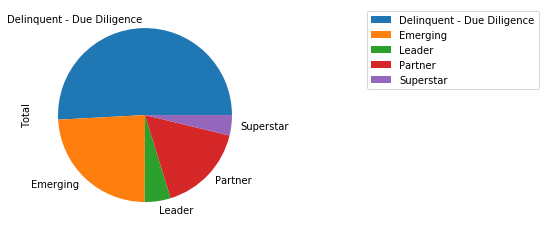

In [342]:
plot = status_summary.plot.pie(y=0).legend(bbox_to_anchor=(1.5, 1))

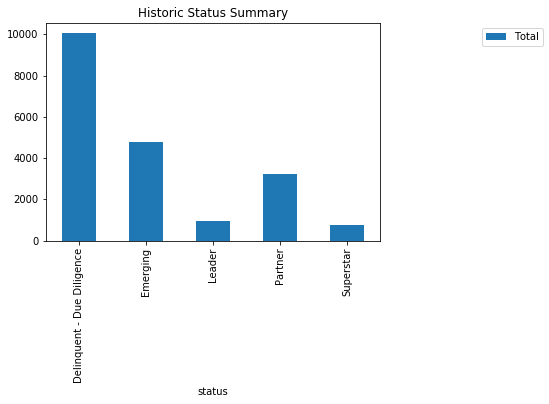

In [343]:
status_summary.plot(kind='bar', title = 'Historic Status Summary', secondary_y=['col b']).legend(bbox_to_anchor=(1.5, 1))


## Retention Based on Status

In [344]:
data_subset = data[['id','status']]

In [345]:
data_subset['original_vetting'] = pd.to_datetime(data.original_vetting_approval_date)
data_subset['recent_vetting'] = pd.to_datetime(data.most_recent_vetting_approval_date)
data_subset['expired_vetting'] = pd.to_datetime(data.vetting_expiration_date)

In [346]:
data_subset

,id,status,original_vetting,recent_vetting,expired_vetting
0,8,Delinquent - Due Diligence,2013-02-26,2013-02-26,2015-02-26
1,11,Partner,2010-07-16,2019-10-10,2021-10-10
2,12,Leader,2011-11-14,2020-01-06,2022-01-06
3,15,Partner,2013-01-22,2020-05-13,2022-05-13
4,35,Superstar,2008-03-12,2019-10-10,2021-10-10
...,...,...,...,...,...
19749,86210,Partner,2020-09-01,2020-09-01,2022-09-01
19750,86228,Partner,2020-09-08,2020-09-08,2022-09-08
19751,86231,Partner,2020-09-06,2020-09-06,2022-09-06
19752,86242,Partner,2020-09-08,2020-09-08,2022-09-08


In [347]:
# some NaT values
data_subset.sort_values(by='original_vetting')

,id,status,original_vetting,recent_vetting,expired_vetting
10,84,Delinquent - Due Diligence,2004-06-16,2004-06-16,2006-06-16
68,496,Leader,2006-03-01,2019-10-09,2021-10-09
48,421,Delinquent - Due Diligence,2006-04-05,2006-04-05,2008-04-05
81,549,Partner,2006-04-20,2020-03-11,2022-03-11
29,300,Partner,2006-04-21,2019-10-09,2021-10-09
...,...,...,...,...,...
17137,70728,Delinquent - Due Diligence,NaT,NaT,NaT
17272,71279,Emerging,NaT,NaT,2021-10-07
17526,72396,Delinquent - Due Diligence,NaT,NaT,NaT
17893,74054,Delinquent - Due Diligence,NaT,NaT,NaT


In [348]:
# drop rows with NaT vals
data_subset = data_subset.dropna()

In [349]:
data_subset.sort_values(by='original_vetting')

,id,status,original_vetting,recent_vetting,expired_vetting
10,84,Delinquent - Due Diligence,2004-06-16,2004-06-16,2006-06-16
68,496,Leader,2006-03-01,2019-10-09,2021-10-09
48,421,Delinquent - Due Diligence,2006-04-05,2006-04-05,2008-04-05
81,549,Partner,2006-04-20,2020-03-11,2022-03-11
29,300,Partner,2006-04-21,2019-10-09,2021-10-09
...,...,...,...,...,...
19720,85403,Partner,2020-09-09,2020-09-09,2022-09-09
19714,85216,Partner,2020-09-09,2020-09-09,2022-09-09
19680,84761,Partner,2020-09-09,2020-09-09,2022-09-09
10686,42054,Emerging,2020-09-10,2020-09-10,2022-09-10


In [350]:
len(data_subset)

15880

### past one year history: Sep 1, 2019 - Sep 1, 2020

In [351]:
import datetime
# current number of active (vetted) organizations
data_subset['Sep 1 2019'] = data_subset.expired_vetting > datetime.date(2019, 9, 1)
data_subset['Oct 1 2019'] = data_subset.expired_vetting > datetime.date(2019, 10, 1)
data_subset['Nov 1 2019'] = data_subset.expired_vetting > datetime.date(2019, 11, 1)
data_subset['Dec 1 2019'] = data_subset.expired_vetting > datetime.date(2019, 12, 1)
data_subset['Jan 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 1, 1)
data_subset['Feb 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 2, 1)
data_subset['Mar 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 3, 1)
data_subset['Apr 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 4, 1)
data_subset['May 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 5, 1)
data_subset['Jun 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 6, 1)
data_subset['Jul 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 7, 1)
data_subset['Aug 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 8, 1)
data_subset['Sep 1 2020'] = data_subset.expired_vetting > datetime.date(2020, 9, 1)

In [352]:
data_subset

,id,status,original_vetting,recent_vetting,expired_vetting,Sep 1 2019,Oct 1 2019,Nov 1 2019,Dec 1 2019,Jan 1 2020,Feb 1 2020,Mar 1 2020,Apr 1 2020,May 1 2020,Jun 1 2020,Jul 1 2020,Aug 1 2020,Sep 1 2020
0,8,Delinquent - Due Diligence,2013-02-26,2013-02-26,2015-02-26,False,False,False,False,False,False,False,False,False,False,False,False,False
1,11,Partner,2010-07-16,2019-10-10,2021-10-10,True,True,True,True,True,True,True,True,True,True,True,True,True
2,12,Leader,2011-11-14,2020-01-06,2022-01-06,True,True,True,True,True,True,True,True,True,True,True,True,True
3,15,Partner,2013-01-22,2020-05-13,2022-05-13,True,True,True,True,True,True,True,True,True,True,True,True,True
4,35,Superstar,2008-03-12,2019-10-10,2021-10-10,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19749,86210,Partner,2020-09-01,2020-09-01,2022-09-01,True,True,True,True,True,True,True,True,True,True,True,True,True
19750,86228,Partner,2020-09-08,2020-09-08,2022-09-08,True,True,True,True,True,True,True,True,True,True,True,True,True
19751,86231,Partner,2020-09-06,2020-09-06,2022-09-06,True,True,True,True,True,True,True,True,True,True,True,True,True
19752,86242,Partner,2020-09-08,2020-09-08,2022-09-08,True,True,True,True,True,True,True,True,True,True,True,True,True


In [353]:
# number of retained organizations
data_subset['Sep 2019 retained'] = (data_subset['Oct 1 2019'] == True) & (data_subset['Sep 1 2019'] == True)
data_subset['Oct 2019 retained'] = (data_subset['Nov 1 2019'] == True) & (data_subset['Oct 1 2019'] == True)
data_subset['Nov 2019 retained'] = (data_subset['Dec 1 2019'] == True) & (data_subset['Nov 1 2019'] == True)
data_subset['Dec 2019 retained'] = (data_subset['Jan 1 2020'] == True) & (data_subset['Dec 1 2019'] == True)
data_subset['Jan 2020 retained'] = (data_subset['Feb 1 2020'] == True) & (data_subset['Jan 1 2020'] == True)
data_subset['Feb 2020 retained'] = (data_subset['Mar 1 2020'] == True) & (data_subset['Feb 1 2020'] == True)
data_subset['Mar 2020 retained'] = (data_subset['Apr 1 2020'] == True) & (data_subset['Mar 1 2020'] == True)
data_subset['Apr 2020 retained'] = (data_subset['May 1 2020'] == True) & (data_subset['Apr 1 2020'] == True)
data_subset['May 2020 retained'] = (data_subset['Jun 1 2020'] == True) & (data_subset['May 1 2020'] == True)
data_subset['Jun 2020 retained'] = (data_subset['Jul 1 2020'] == True) & (data_subset['Jun 1 2020'] == True)
data_subset['Jul 2020 retained'] = (data_subset['Aug 1 2020'] == True) & (data_subset['Jul 1 2020'] == True)
data_subset['Aug 2020 retained'] = (data_subset['Sep 1 2020'] == True) & (data_subset['Aug 1 2020'] == True)

In [354]:
data_subset

,id,status,original_vetting,recent_vetting,expired_vetting,Sep 1 2019,Oct 1 2019,Nov 1 2019,Dec 1 2019,Jan 1 2020,...,Nov 2019 retained,Dec 2019 retained,Jan 2020 retained,Feb 2020 retained,Mar 2020 retained,Apr 2020 retained,May 2020 retained,Jun 2020 retained,Jul 2020 retained,Aug 2020 retained
0,8,Delinquent - Due Diligence,2013-02-26,2013-02-26,2015-02-26,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,11,Partner,2010-07-16,2019-10-10,2021-10-10,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,12,Leader,2011-11-14,2020-01-06,2022-01-06,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,15,Partner,2013-01-22,2020-05-13,2022-05-13,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,35,Superstar,2008-03-12,2019-10-10,2021-10-10,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19749,86210,Partner,2020-09-01,2020-09-01,2022-09-01,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
19750,86228,Partner,2020-09-08,2020-09-08,2022-09-08,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
19751,86231,Partner,2020-09-06,2020-09-06,2022-09-06,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
19752,86242,Partner,2020-09-08,2020-09-08,2022-09-08,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [355]:
data_subset.columns

Index(['id', 'status', 'original_vetting', 'recent_vetting', 'expired_vetting',
       'Sep 1 2019', 'Oct 1 2019', 'Nov 1 2019', 'Dec 1 2019', 'Jan 1 2020',
       'Feb 1 2020', 'Mar 1 2020', 'Apr 1 2020', 'May 1 2020', 'Jun 1 2020',
       'Jul 1 2020', 'Aug 1 2020', 'Sep 1 2020', 'Sep 2019 retained',
       'Oct 2019 retained', 'Nov 2019 retained', 'Dec 2019 retained',
       'Jan 2020 retained', 'Feb 2020 retained', 'Mar 2020 retained',
       'Apr 2020 retained', 'May 2020 retained', 'Jun 2020 retained',
       'Jul 2020 retained', 'Aug 2020 retained'],
      dtype='object')

In [356]:
# x axis (dates)
date1 = '2019-09'
date2 = '2020-09'
mydates = pd.date_range(date1, date2, freq='M').tolist()

In [358]:
# y axis (retention rates)
retention = []
for i in range(12):
    retention.append(data_subset.iloc[:,i+18].sum()/data_subset.iloc[:,i+5].sum()*100)

In [359]:
retention

[98.86968807738289,
 99.24150818951303,
 99.2135578201152,
 98.81656804733728,
 99.20912891198735,
 99.2028242796948,
 98.95534381816094,
 99.46635730858469,
 99.51014695591323,
 99.6601031411158,
 99.29436669410796,
 98.23522444628686]

Text(0.5, 0, 'Month')

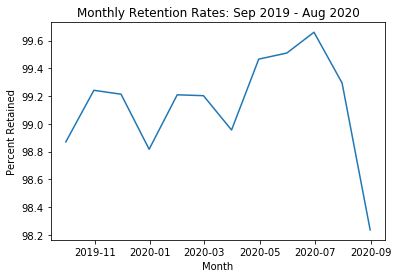

In [360]:
# plot
plt.plot(mydates, retention)
plt.title('Monthly Retention Rates: Sep 2019 - Aug 2020')
plt.ylabel('Percent Retained')
plt.xlabel('Month')

In [361]:
# length of time retained
data_subset['duration'] = data_subset.expired_vetting - data_subset.original_vetting

In [362]:
# median duration of retention (across all time)
data_subset.duration.median()

Timedelta('731 days 00:00:00')

In [363]:
# mean duration of retention (across all time)
data_subset.duration.mean()

Timedelta('1183 days 02:43:08.010068')